In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score)
from sklearn.pipeline import Pipeline

from my_awesome_eda import run_eda

In [2]:
SEED = 36

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [3]:
data = pd.read_csv("../data_folder/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


Praise the Omnissiah! Welcome to the Sanctum of Exploratory Data Analysis.

Number of Observations (Rows): 17996
Number of Parameters (Columns): 17

Data Types of Each Column:
Artist Name          object
Track Name           object
Popularity           float64
danceability         float64
energy               float64
key                  float64
loudness             float64
mode                 int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
duration_in min/ms   float64
time_signature       int64
Class                int64

Numerical features: Popularity, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_in min/ms, time_signature, Class
String features: Artist Name, Track Name
Categorical features: 0

Counts and Frequencies for Categorical Features:

Descriptive Statistics for Numeric

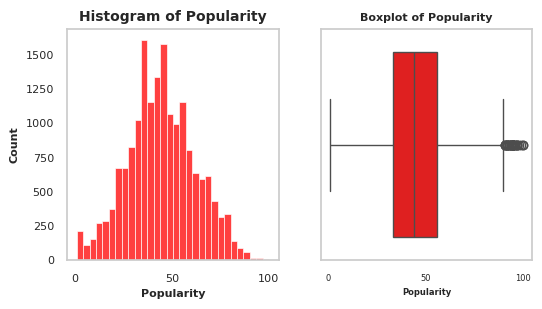

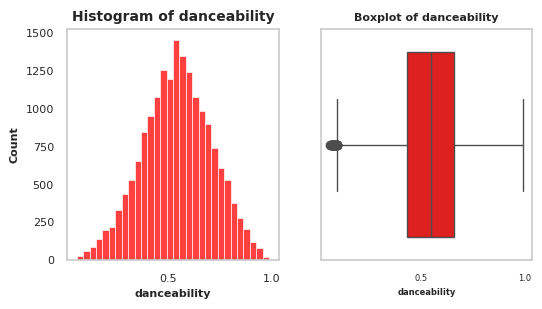

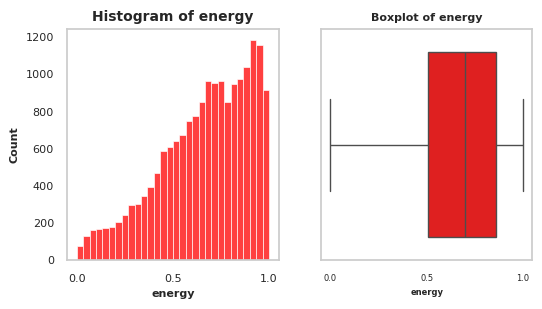

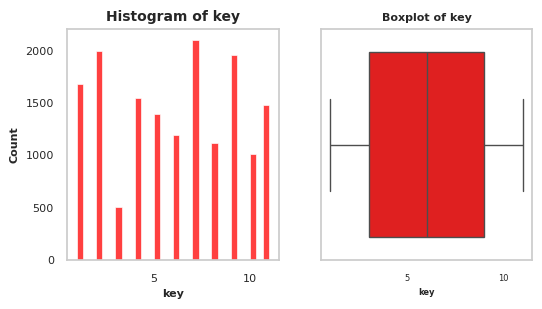

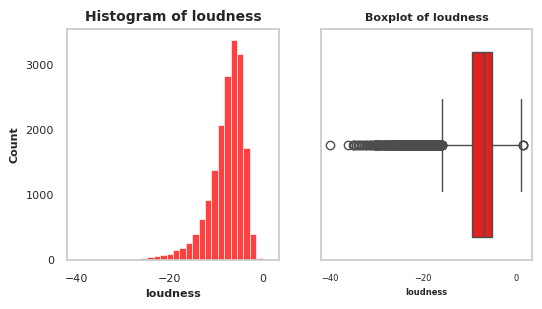

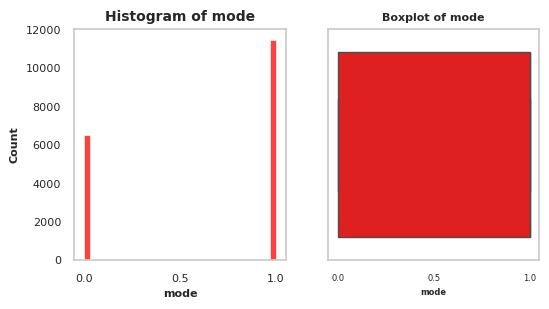

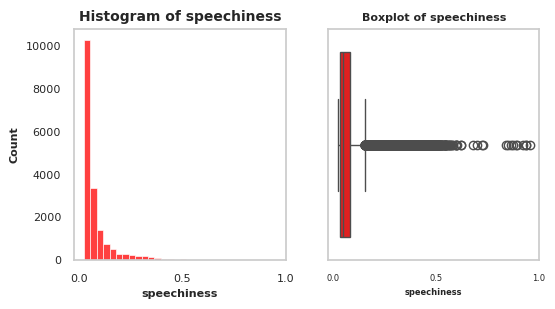

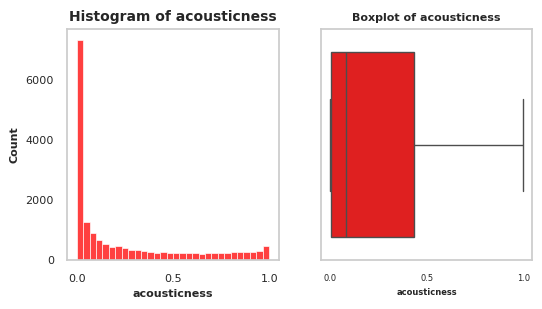

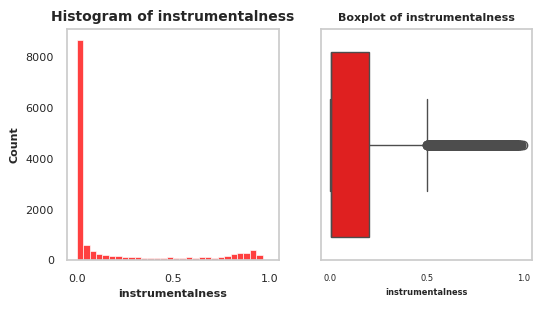

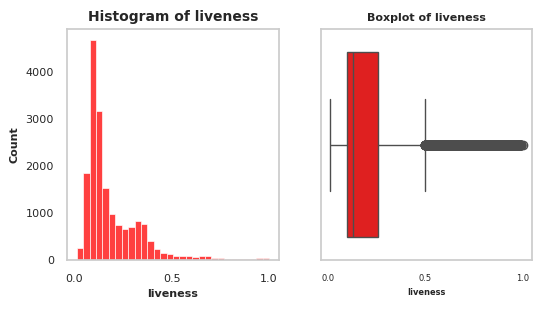

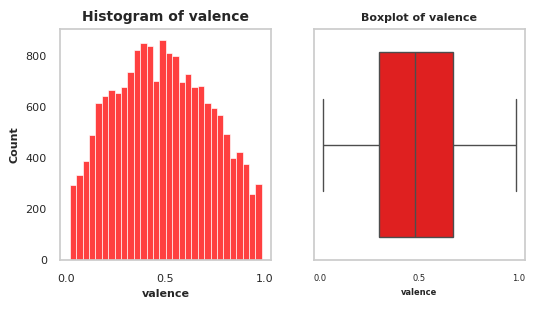

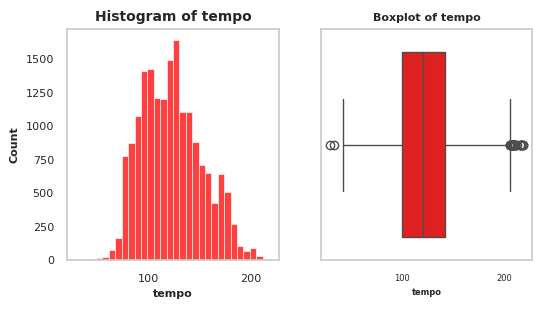

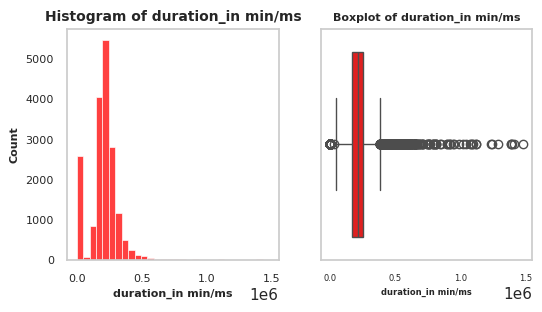

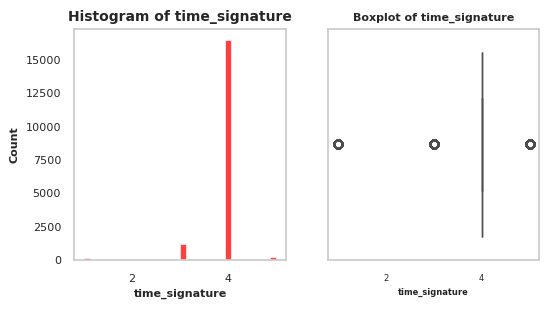

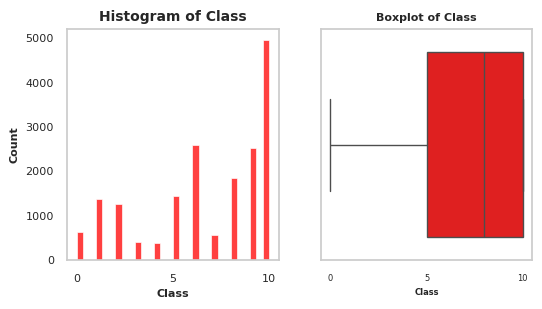


Correlation Heatmap:


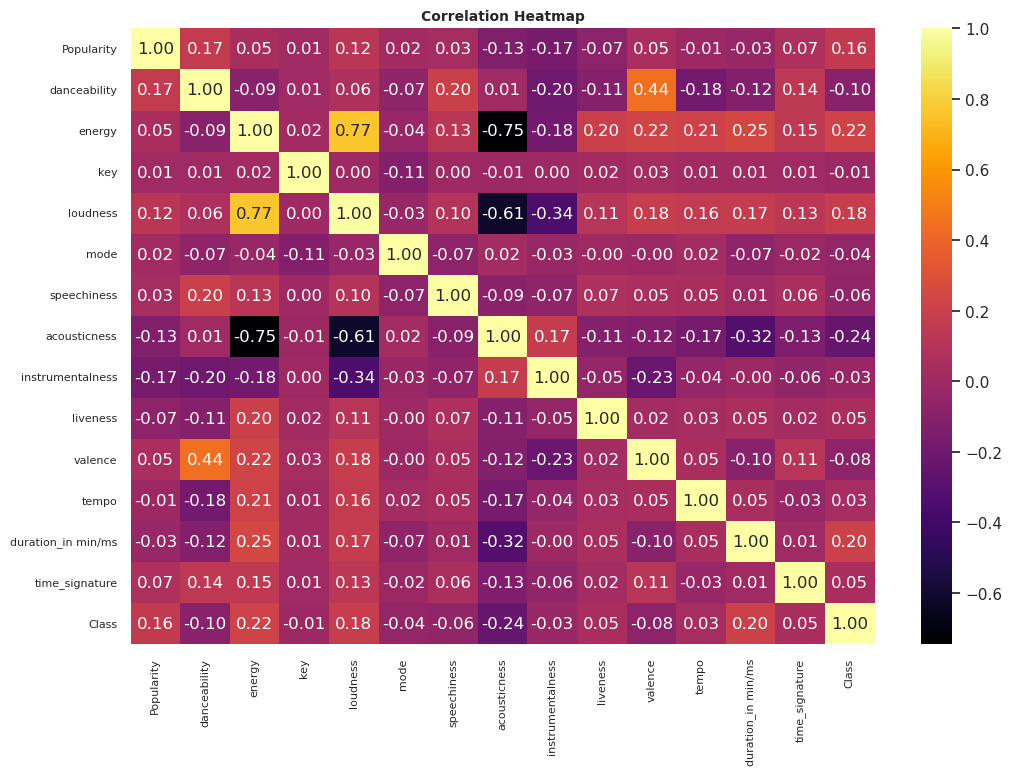


Outliers for Numerical Features:
Popularity: 41
danceability: 31
energy: 0
key: 0
loudness: 818
mode: 0
speechiness: 2034
acousticness: 0
instrumentalness: 2408
liveness: 956
valence: 0
tempo: 36
duration_in min/ms: 3245
time_signature: 1545
Class: 0

Missing Values:
Total Missing Values: 6819
Rows with Missing Values: 6183
Columns with Missing Values: Popularity, key, instrumentalness

Missing Values Proportion:


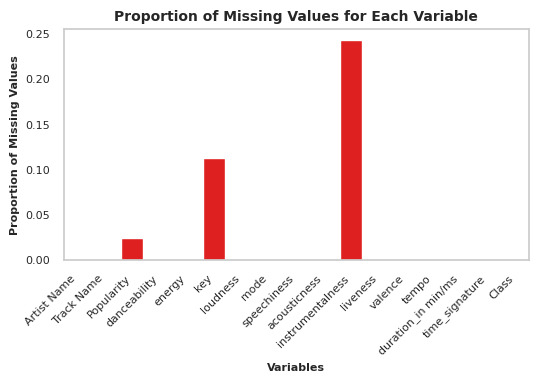


Duplicate Rows:
Number of Duplicate Rows: 0

May the data guide you, and the Omnissiah bless your analysis.


In [4]:
run_eda(data)

Итак, у нас есть 17996 наблюдений (прям много) и 17 параметров. Первый с конца (таблицы, но не по значению) параметр - это наш таргет *Class*, жанр музыки, где закодированы некоторые значения, например Rock, Indie, Alt, Pop, Metal, HipHop, Alt_Music, Blues, Acoustic/Folk, Instrumental, Country, Bollywood. В описании датасета их 12, а значений у нас 11, так что я не очень могу сопоставить жанры и лейблы. Наблюдается дисбаланс классов, много 10го класса, почти 5 тысяч наблюдений, а 0, 3, 4 и 7 классов меньше 1000.

In [5]:
data['Class'].value_counts()

Class
10    4949
6     2587
9     2524
8     1854
5     1447
1     1373
2     1272
0      625
7      576
3      402
4      387
Name: count, dtype: int64

In [6]:
X, y = data.iloc[:, 0:16], data.iloc[:, 16]

Далее, у нас есть следующие параметры:
1. Artist Name: исполнитель музыкального трека. Штука важная, потому что на самом деле по имени исполнителя или группы можно достаточно точно предсказать жанр. Но уникальных значений 9149, как такое закодировать-то? Придется отказаться от этого параметра.

In [7]:
X['Artist Name'].nunique()

9149

2. Track Name: название музыкального трека. Это мы выкинем. Например, я знаю несколько песен в плюс-минус разных жанрах с названием "Радиоволна", пару песен с названием "Seeman", уверена - это не все) А еще есть каверы. Мой любимый кавер - это "Ooops, I did it again" от Children of Bodom, совсем другой жанр.
3. Popularity: популярность трека, числовая переменная. Хорошее распределение признака, есть какие-то супер-популярные треки, 41 штука, но мы их оставим. Есть 428 пропущенных значений. Заполним их, может быть как-то по хитрому.

In [8]:
X['Popularity'].isna().sum()

428

4. danceability: танцевальность трека, числовая переменная (чтобы это не значило). Хорошее распределение признака, нет пропущенных значений, 31 трек какой-то не очень танцевальный, сразу ясно, что не Боливуд, оставим эти наблюдения.
5. energy: энергия трека, числовая переменная. Распределение не нормальное, выбросов нет. Есть положительная корреляция с громкостью, и отрицательная с акустичностью. Эх, люблю по утрам послушать что-то энергичное, например Erwache (Die Apokalyptischen Reiter).
6. key: тональность трека, закодированная числом категориальная переменная. Есть 2014 пропущенныx значения. Попробуем их заполнить.

In [9]:
print(f'Количество уникальных значений: {X['key'].nunique()} (на самом деле {X['key'].nunique() - 1}, если не считать NA)')
print(f'Количесвто пропущенных значений: {X['key'].isna().sum()}')

Количество уникальных значений: 11 (на самом деле 10, если не считать NA)
Количесвто пропущенных значений: 2014


7. loudness: громкость трека, числовая переменная. Пропущенных значений нет, есть какие-то совсем тихие треки в количестве 818 штук (акустика?), не будем их выкидывать. У данной переменной положительная корреляция с энергией и отрицательная с акустичностью.
8. mode: режим трека, категориальная переменная, возможно "мажор" и "минор". Пропущенных значений нет.
9. speechiness: речевая активность, разговорчивость (перевел мне DeepL), числовая переменная вероятно представляющая долю речевых элементов в треке. Распределение признака не нормальное. Много неразговорчивых треков, но есть какие-то с большой речевой активностью (Хип-хоп?)
10. acousticness: акустичность трека, числовая переменная. Признак распределен не нормально. Отрицательная корреляция с энергией и громкостью.
11. instrumentalness: инструментальность трека, числовая переменная. Распределение признака не нормальное, пропущенных значений 4377. Попробуем заполнить их, не будем выкидывать.

In [10]:
X['instrumentalness'].isna().sum()

4377

12. liveness: живость трека, числовая переменная. Распределена не нормально, пропущенных значений нет.
13. valence: настроение трека, числовая переменная. Распределение нормальное, выбросов нет, пропущенных значений нет.
14. tempo: темп трека, числовая переменная, вероятно скорость музыкального трека в ударах в минуту (BPM, привет метроном). Распределение близко к нормальному, пропущенных значений нет.
15. duration_in min/ms: продолжительность трека. Мне не нравится эта колонка, потому что видимо часть продолжительности треков записана в минутах, часть в милисекундах, я хочу ее удалить.

In [11]:
np.sort(X['duration_in min/ms'].unique())

array([5.01650000e-01, 5.33916667e-01, 9.69150000e-01, ...,
       1.39266700e+06, 1.41245100e+06, 1.47718700e+06])

16. time_signature: временная сигнатура трека, указывающая на количество долей в одном такте (?), категориальная переменная. Примерно 90% наблюдений имеют значение 4, но вдруг вот этот нестандартный темп - признак конкретного жанра. Оставим эту колонку, пожалуй.

In [12]:
X['time_signature'].value_counts()

time_signature
4    16451
3     1228
5      203
1      114
Name: count, dtype: int64

План действий:
1. Убираем исполнителя, название песни и время трека.
2. Построим регрессионные модельки для заполнения пропущенных значений для 1 категориальной (key) и двух числовых (Popularity, instrumentalness) фичей.
3. Посмотрим еще раз на наши данные.
4. Сделаем препроцессинг наших данных, в том числе  - перекодируем категориальные фичи: key, mode, time_signature.
5. Разделим выборки на трейн и тест.
6. Пойдем сажать и растить наше дерево.

In [13]:
X_cleaned = X.drop(['Artist Name', 'Track Name', 'duration_in min/ms'], axis=1)
X_cleaned.head()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,4
1,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,4
2,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,4
3,66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,4
4,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,4


In [14]:
X_key = X_cleaned.drop(['Popularity', 'instrumentalness'], axis=1)
X_pop = X_cleaned.drop(['key', 'instrumentalness'], axis=1)
X_inst = X_cleaned.drop(['Popularity', 'key'], axis=1)

In [15]:
cat_cols = ['mode', 'time_signature']
num_cols = ['danceability', 'energy', 'loudness', 'speechiness','acousticness', 'liveness', 'valence', 'tempo']
all_features = cat_cols + num_cols

In [16]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_cols)
])
preprocessor

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['danceability', 'energy', 'loudness',
                                  'speechiness', 'acousticness', 'liveness',
                                  'valence', 'tempo']),
                                ('ohe', OneHotEncoder(drop='first'),
                                 ['mode', 'time_signature'])])

In [17]:
logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logreg", LogisticRegression())
])
logreg_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness', 'liveness',
                                                   'valence', 'tempo']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['mode',
                                                   'time_signature'])])),
                ('logreg', LogisticRegression())])

In [18]:
X_key_without_na = X_key.dropna()
X_key_train = X_key_without_na.drop(['key'], axis=1)
y_key_train = X_key_without_na['key']

logreg_pipeline.fit(X_key_train, y_key_train)
# возможно это не предсказание мечты, но хочу немного осмысленно заполнить пропущенные значения
# а еще под финал можно дропнуть все пропущенные значения и посмотреть, как лучше))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness', 'liveness',
                                                   'valence', 'tempo']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['mode',
                                                   'time_signature'])])),
                ('logreg', LogisticRegression())])

In [19]:
X_key_missing = X_cleaned[X_cleaned['key'].isnull()].drop(['key'], axis=1)
predicted_key = logreg_pipeline.predict(X_key_missing)

X_cleaned.loc[X_cleaned['key'].isnull(), 'key'] = predicted_key

In [20]:
linreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lin_reg", LinearRegression())
])
linreg_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness', 'liveness',
                                                   'valence', 'tempo']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['mode',
                                                   'time_signature'])])),
                ('lin_reg', LinearRegression())])

In [21]:
X_pop_without_na = X_pop.dropna()
X_pop_train = X_pop_without_na.drop(['Popularity'], axis=1)
y_pop_train = X_pop_without_na['Popularity']

linreg_pipeline.fit(X_pop_train, y_pop_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness', 'liveness',
                                                   'valence', 'tempo']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['mode',
                                                   'time_signature'])])),
                ('lin_reg', LinearRegression())])

In [22]:
X_pop_missing = X_cleaned[X_cleaned['Popularity'].isnull()].drop(['Popularity'], axis=1)
predicted_pop = linreg_pipeline.predict(X_pop_missing)

X_cleaned.loc[X_cleaned['Popularity'].isnull(), 'Popularity'] = predicted_pop

In [23]:
X_inst_without_na = X_inst.dropna()
X_inst_train = X_inst_without_na.drop(['instrumentalness'], axis=1)
y_inst_train = X_inst_without_na['instrumentalness']

linreg_pipeline.fit(X_inst_train, y_inst_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness', 'liveness',
                                                   'valence', 'tempo']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['mode',
                                                   'time_signature'])])),
                ('lin_reg', LinearRegression())])

In [24]:
X_inst_missing = X_cleaned[X_cleaned['instrumentalness'].isnull()].drop(['instrumentalness'], axis=1)
predicted_inst = linreg_pipeline.predict(X_inst_missing)

X_cleaned.loc[X_cleaned['instrumentalness'].isnull(), 'instrumentalness'] = predicted_inst

Praise the Omnissiah! Welcome to the Sanctum of Exploratory Data Analysis.

Number of Observations (Rows): 17996
Number of Parameters (Columns): 13

Data Types of Each Column:
Popularity         float64
danceability       float64
energy             float64
key                category
loudness           float64
mode               category
speechiness        float64
acousticness       float64
instrumentalness   float64
liveness           float64
valence            float64
tempo              float64
time_signature     category

Numerical features: Popularity, danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo
String features: 0
Categorical features: key, mode, time_signature

Counts and Frequencies for Categorical Features:
      count  Frequency
key                   
1.0    1822   0.101245
2.0    2640   0.146699
3.0     509   0.028284
4.0    1624   0.090242
5.0    1460   0.081129
6.0    1192   0.066237
7.0    2777   0.154312
8.0    1119

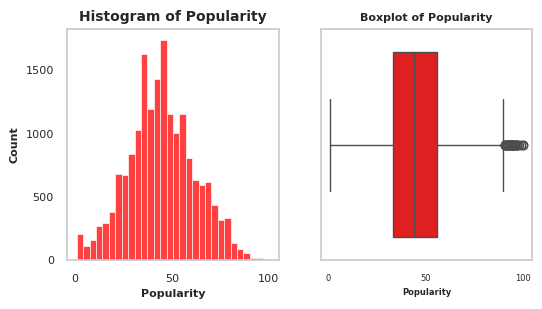

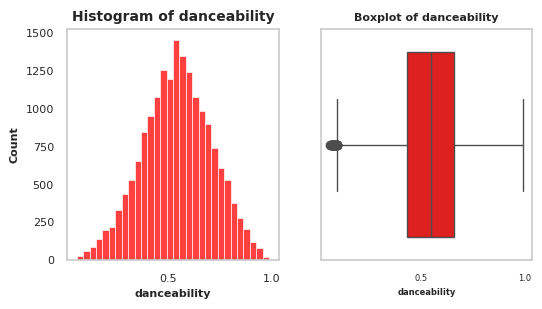

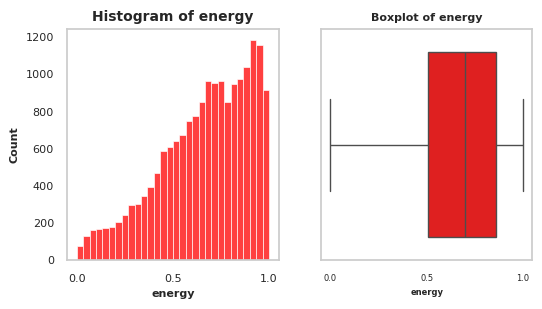

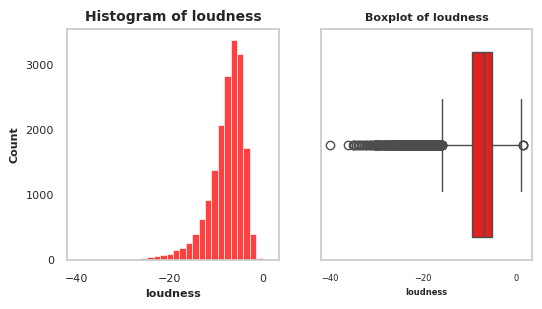

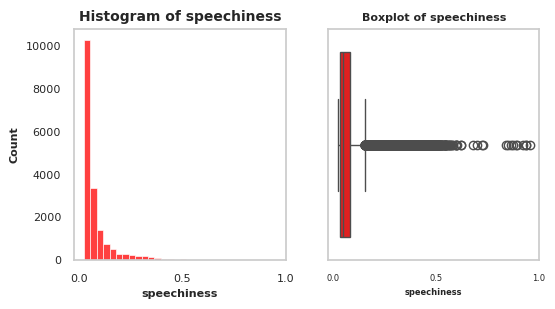

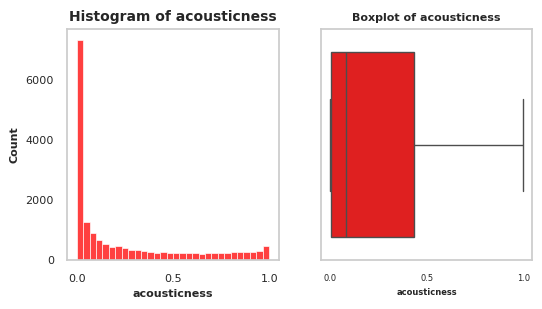

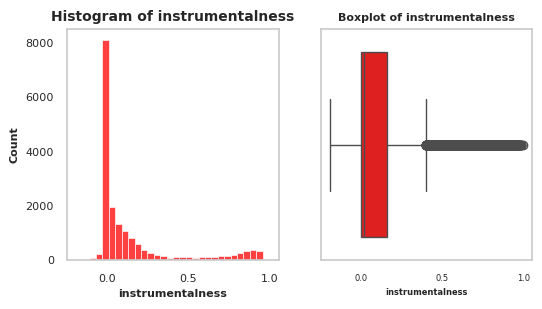

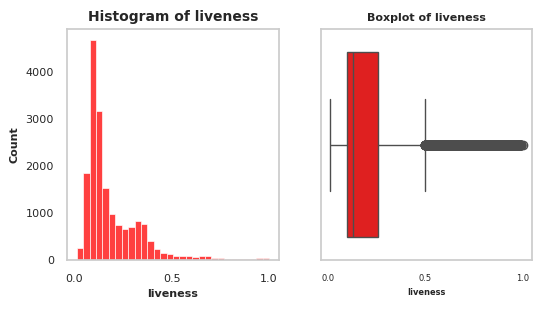

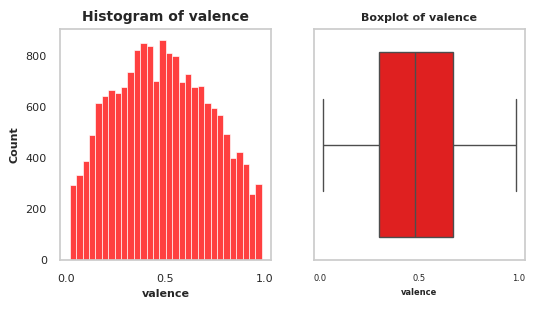

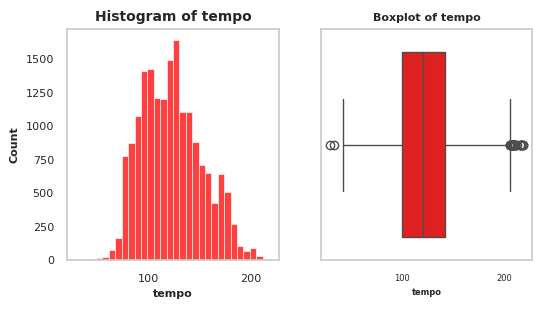


Correlation Heatmap:


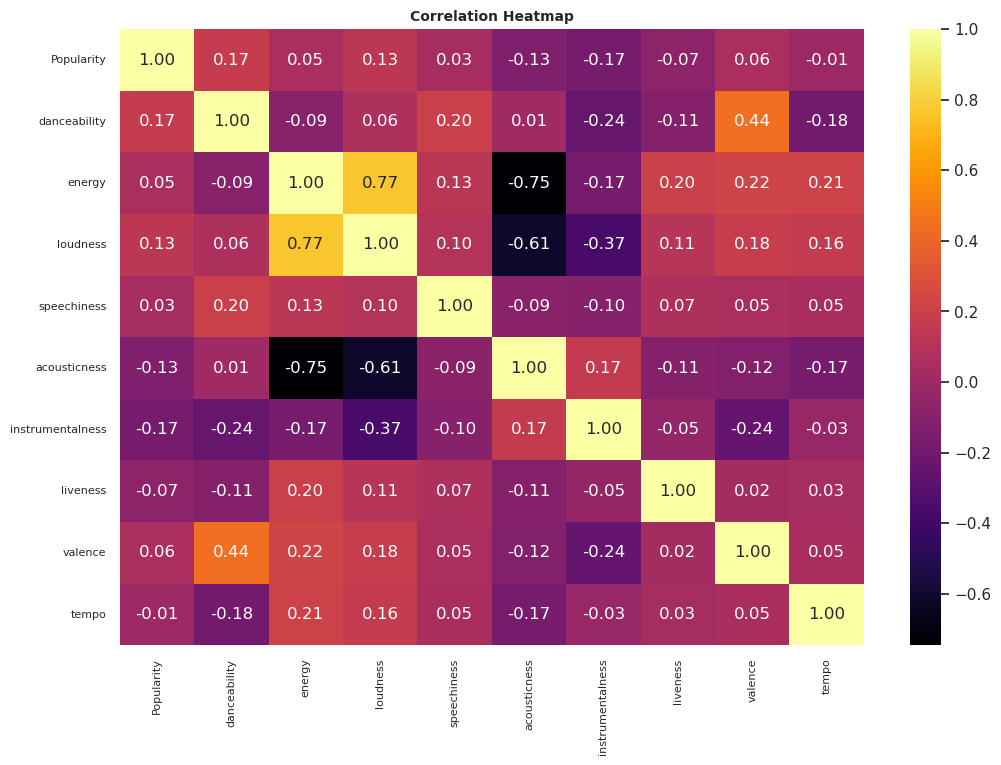


Outliers for Numerical Features:
Popularity: 41
danceability: 31
energy: 0
loudness: 818
speechiness: 2034
acousticness: 0
instrumentalness: 2722
liveness: 956
valence: 0
tempo: 36

Missing Values:
Total Missing Values: 0
Rows with Missing Values: 0
Columns with Missing Values: 

Missing Values Proportion:


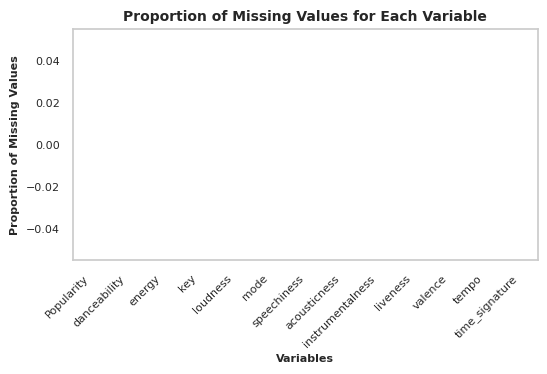


Duplicate Rows:
Number of Duplicate Rows: 1772

May the data guide you, and the Omnissiah bless your analysis.


In [25]:
run_eda(X_cleaned, category_values=11)

Вот мы заполнили как-то пропущенные значения. Но теперь появились одинаковые ряды))

In [26]:
category_cols = ['key', 'mode', 'time_signature']
numeric_cols = ['Popularity', 'danceability', 'energy', 'loudness', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
all_features = category_cols + numeric_cols

preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), numeric_cols),
    ("ohe", OneHotEncoder(drop="first"), category_cols)
])
preprocessor

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['Popularity', 'danceability', 'energy',
                                  'loudness', 'speechiness', 'acousticness',
                                  'instrumentalness', 'liveness', 'valence',
                                  'tempo']),
                                ('ohe', OneHotEncoder(drop='first'),
                                 ['key', 'mode', 'time_signature'])])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=SEED)

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Упс, часть задания я сделала выше..))

In [59]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': list(range(1, 15)),
    'classifier__min_samples_split':list(range(2, 5)),
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced', None]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['Popularity',
                                                                          'danceability',
                                                                          'energy',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'valence',
                                                                          'tempo']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['key',
                                                                          'mode',
                                                                          'time_signature'])])),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 3, 4]},
             scoring='f1_macro')

In [73]:
print(f'Best Hyperparameters: {grid_search.best_params_}')
print(f'Best F1 score: {grid_search.best_score_}')

Best Hyperparameters: {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 11, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 4}
Best F1 score: 0.35187411481485953


In [64]:
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', grid_search.best_estimator_.named_steps['classifier'])
])

best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Popularity', 'danceability',
                                                   'energy', 'loudness',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['key', 'mode',
                                                   'time_signature'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=11, min_samples_leaf=4,
                                        min_samples_split=4))])

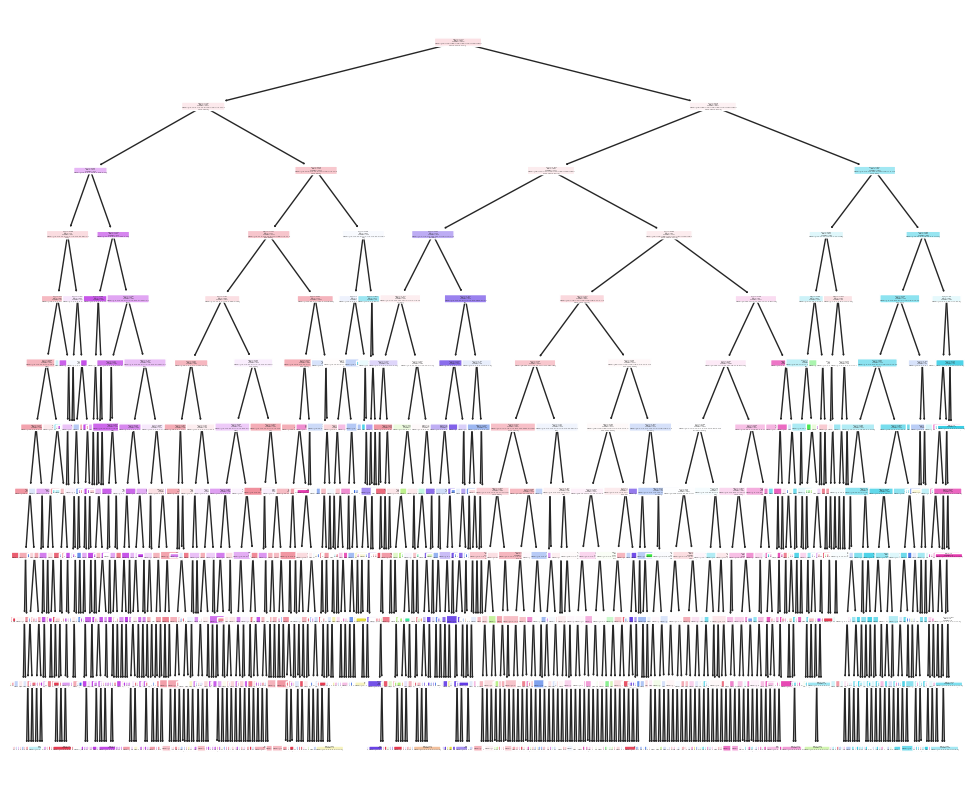

In [82]:
decision_tree_model = best_pipeline['classifier']

plt.figure(figsize=(12, 10))
plot_tree(decision_tree_model, filled=True, rounded=True)
plt.show()

Получилось как в песне - "Я думал, будет хорошо, а вышло не очень". 

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1.

2.

3.